### Summary
With reference to fastai Deep Learning course lesson 2, we implement the general steps suggested by Jeremy Howard on our dress data project. The general steps are described as follows:
1. Enable data augmentation, and precompute = True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for several epochs
4. Train last later with data augmentation (precompute = False) for another several epochs with cycle_len = 1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult = 2 until over-fitting
9. Apply Test Time Augmentation for Predictions


In [0]:
#Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import matplotlib.pyplot as plt

In [0]:
PATH = '/content/selected_gd_data/'
# image size may need to adjust
sz = 224

#### 1. Enable Data  Augementation

In [0]:
arch = resnet34
# flip sideways, vary the contrast, blur, zoom-in
tfms = tfms_from_model(resnet34, 
                       sz, 
                       # transform_top_down: flip vertically
                       # transform_side_on: flip horizontally
                       aug_tfms = transforms_side_on,
                       max_zoom = 1.1)

In [0]:
def get_augs():
  data = ImageClassifierData.from_paths(PATH, 
                                        bs = 2,
                                        trn_name = 'imgtrain',
                                        val_name = 'imgval',
                                        tfms = tfms, 
                                        num_workers = 1)
  x, _ = next(iter(data.aug_dl))
  return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

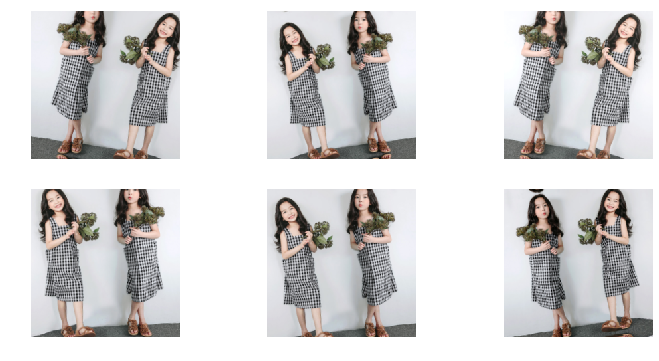

In [0]:
plots(ims, rows = 2)

#### 2. Find Suitable Learning Rate

In [0]:
# Create a new data object with augmented data included
data = ImageClassifierData.from_paths(PATH, 
                                      tfms = tfms,
                                      trn_name = 'imgtrain',
                                      val_name = 'imgval')

# when precompute = True, data augmentation not work
learn = ConvLearner.pretrained(arch, data, precompute = True)

lrf = learn.lr_find(1e-7,1e2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 27840434.63it/s]


100%|██████████| 24/24 [00:27<00:00,  2.55it/s]


 76%|███████▌  | 142/187 [00:03<00:00, 55.04it/s, loss=9.9] 


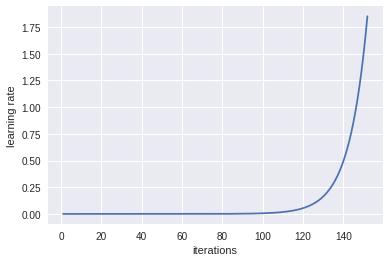

In [0]:
learn.sched.plot_lr()

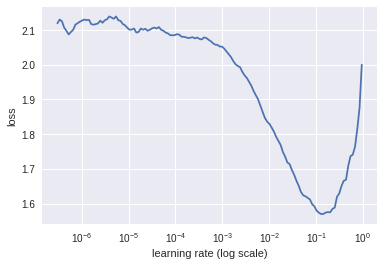

In [0]:
# Find the learning rate with highest decrease in loss function
# From the graph, lr = 0.01 is appropriate
learn.sched.plot()

#### 3. Train Last Layers with Precomputed Activation

In [0]:
# This learning has no data augmentation included
learn.fit(1e-2, 10)

epoch      trn_loss   val_loss   accuracy   
    0      0.942554   0.747651   0.706275  
    1      0.825777   0.711538   0.722296  
    2      0.79366    0.690281   0.728304  
    3      0.744619   0.651348   0.736983  
    4      0.735386   0.635162   0.757009  
    5      0.698741   0.623301   0.751669  
    6      0.674664   0.62624    0.760347  
    7      0.627283   0.604167   0.763685  
    8      0.607504   0.592723   0.780374  
    9      0.578507   0.593859   0.787049  



[array([0.59386]), 0.7870493991193529]

#### 4. Train Last Layers with Data Augmentation

In [0]:
# set precompute = False and learn again
# This time augmented data is included
learn.precompute = False

# cycle_len = 1
# [learning rate (cosine) annealing] decrease learning rate with iterations
# reset learning rate to its peak at every epoch
# gradually decrease learning rate for each minibatch
# Note that we are training the last layer (randomly initialized)
learn.fit(1e-2, 10, cycle_len = 1)

epoch      trn_loss   val_loss   accuracy   
    0      0.657424   0.580153   0.777036  
    1      0.65562    0.573222   0.780374  
    2      0.634757   0.564082   0.787049  
    3      0.657247   0.573292   0.782377  
    4      0.625705   0.566298   0.785047  
    5      0.607178   0.561224   0.783044  
    6      0.611942   0.556125   0.788385  
    7      0.599932   0.555186   0.796395  
    8      0.603665   0.556044   0.787717  
    9      0.600568   0.544897   0.793057  



[array([0.5449]), 0.7930574097206818]

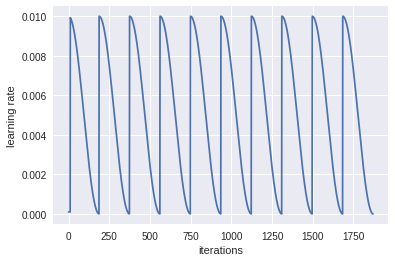

In [0]:
learn.sched.plot_lr()

In [0]:
# save the model
# It is saved in {PATH}/models
learn.save('224_dress_lastlayer')
# load in the model
learn.load('224_dress_lastlayer')

#### 5. Unfreeze All Layers

In [0]:
# unfreeze the remaining layers
# unfreeze layer from n onwards
learn.unfreeze()

#### 6. Find Suitable Learning Rate Again

In [0]:
# Let's see if the optimal learning rate has changed after we trained the last layer
lrf = learn.lr_find(1e-16,1e-2)

epoch      trn_loss   val_loss   accuracy   
    0      0.806028   0.860939   0.669559  


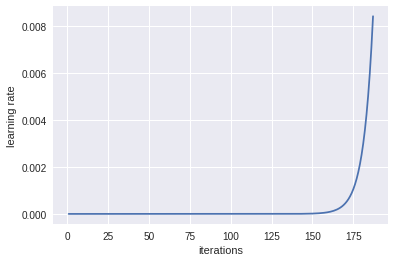

In [0]:
learn.sched.plot_lr()

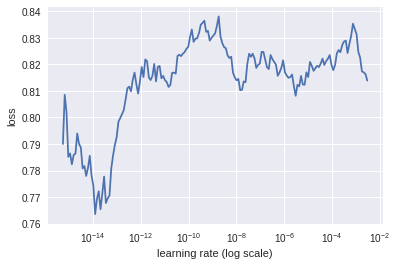

In [0]:
# Find the learning rate with highest decrease in loss function
# From the graph, lr = 0.01 is appropriate
learn.sched.plot()

#### 7. Apply Differential Learning Rate

In [0]:
# The most shallow layers need little training
# The deepest layers need more training
# shallow > middle > deep
lr = np.array([1e-16, 1e-15, 1e-14])

In [0]:
# stochastics gradient descent: cycle_len = 1
# number of cycles = 3
# each cycle contains 2 epoch
# cycle_mult = 2 - Double the length of cycle for each cycle
# 1 + 2 + 4 epochs
learn.fit(lr, 4, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.829525   0.696946   0.73231   
    1      0.81224    0.688665   0.734312  
    2      0.806795   0.689488   0.739653  
    3      0.829297   0.6995     0.732977  
    4      0.839051   0.702927   0.736983  
    5      0.839031   0.692422   0.736983  
    6      0.820625   0.689451   0.734312  
    7      0.819382   0.694364   0.731642  
    8      0.812632   0.691799   0.739653  
    9      0.829366   0.698743   0.73498   
    10     0.828372   0.696866   0.730975  
    11     0.799905   0.69196    0.73498   
    12     0.846449   0.696089   0.73231   
    13     0.826736   0.701874   0.730975  
    14     0.818256   0.69765    0.730307  


[array([0.69765]), 0.7303070764993634]

#### 9. Analysis of Results
1. Confusion Matrix (with and ithout Test Time Augmentation)
2. Sample Check